In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, concatenate, Dropout
from tensorflow.keras.losses import binary_crossentropy
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

In [3]:
data = np.load('/content/drive/My Drive/U-NET - Implementation/images/original/Clock/samples.npy',allow_pickle=True)
labels = np.load('/content/drive/My Drive/U-NET - Implementation/images/original/Clock/labels.npy',allow_pickle=True)

In [4]:
images = [data[0],labels[0],data[137],labels[137]]
titles = ['Image0','Mask0','Image1','Mask1']


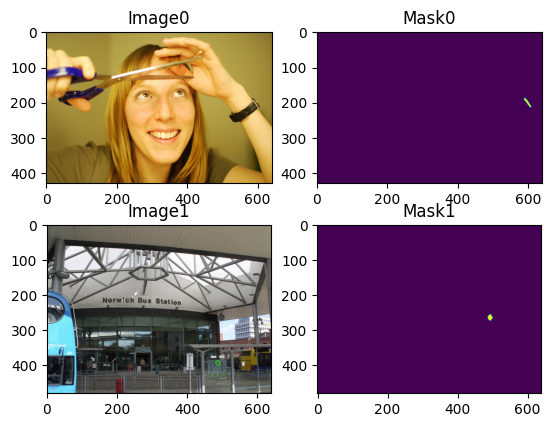

In [5]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i])

In [6]:
def Preprocess_Images_and_Masks(image_data,mask_data,target_img_size,target_mask_size):

    num_images = len(image_data)

    img_height, img_width, img_channels = target_img_size
    mask_height, mask_width, mask_channels = target_mask_size

    X_preprocessed = np.zeros((num_images, img_height, img_width, img_channels),dtype=np.float32)
    y_preprocessed = np.zeros((num_images, mask_height, mask_width, mask_channels),dtype=np.int32)

    for i in range(len(image_data)):

        img = Image.fromarray(image_data[i]).convert('RGB')
        img = img.resize((img_height, img_width))
        img = np.reshape(img,(img_height, img_width, img_channels))
        img = img/255.0
        X_preprocessed[i] = img

        mask = Image.fromarray(mask_data[i])
        mask = mask.resize((mask_height, mask_width))
        mask = np.reshape(mask,(mask_height, mask_width, mask_channels))
        y_preprocessed[i] = mask

    return X_preprocessed, y_preprocessed



In [7]:
target_img_size = [128, 128, 3]
target_mask_size = [128, 128, 1]

preprocessed_images, preprocessed_masks = Preprocess_Images_and_Masks(data,labels,target_img_size,target_mask_size)

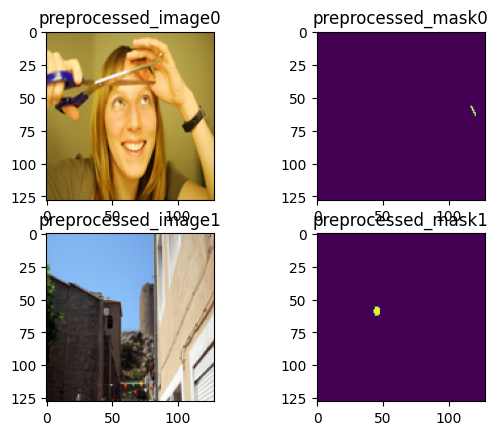

In [10]:
images = [preprocessed_images[0],preprocessed_masks[0],preprocessed_images[373],preprocessed_masks[373]]
titles = ['preprocessed_image0','preprocessed_mask0','preprocessed_image1','preprocessed_mask1']

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(titles[i])

In [11]:
def EncoderBlock(input_to_layer, num_filters, dropout_prob, max_pooling=False):

    conv1 = Conv2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'HeNormal')(input_to_layer)

    conv1 = Conv2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'HeNormal')(conv1)

    conv1 = BatchNormalization()(conv1, training = True)

    if dropout_prob > 0:
        conv1 = Dropout(dropout_prob)(conv1)

    if max_pooling:
        next_encoder_layer = MaxPooling2D(pool_size = (2,2))(conv1)

    else:
        next_encoder_layer = conv1

    skip_connection = conv1

    return next_encoder_layer, skip_connection



In [12]:
def DecoderBlock(previous_layer_input, skip_connect_layer, num_filters):

    up_conv = Conv2DTranspose(num_filters, 3, strides = (2,2), padding = 'same')(previous_layer_input)


    concat = concatenate([up_conv, skip_connect_layer], axis = 3)

    conv2 = Conv2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'HeNormal')(concat)

    conv2 = Conv2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'HeNormal')(conv2)

    return conv2


In [13]:
def UNet(input_dim, num_filters, num_classes):

    input_to_network = Input(input_dim)

    encoder_layer1, skip_connect1 = EncoderBlock(input_to_network, num_filters, dropout_prob=0, max_pooling=True)

    print("Encoder Layer1 Shape = ",encoder_layer1.shape)
    print("skip connect1 shape = ",skip_connect1.shape )

    encoder_layer2, skip_connect2 = EncoderBlock(encoder_layer1, num_filters*2, dropout_prob=0, max_pooling=True)

    print("Encoder Layer2 Shape = ",encoder_layer2.shape)
    print("skip connect2 shape = ",skip_connect2.shape )

    encoder_layer3, skip_connect3 = EncoderBlock(encoder_layer2, num_filters*4, dropout_prob=0, max_pooling=True)

    print("Encoder Layer3 Shape = ",encoder_layer3.shape)
    print("skip connect3 shape = ",skip_connect3.shape )

    encoder_layer4, skip_connect4 = EncoderBlock(encoder_layer3, num_filters*8, dropout_prob=0.3, max_pooling=True)
    print("Encoder Layer4 Shape = ",encoder_layer4.shape)
    print("skip connect4 shape = ",skip_connect4.shape )

    encoder_layer5, skip_connect5 = EncoderBlock(encoder_layer4, num_filters*16, dropout_prob=0.3, max_pooling=False)
    print("Encoder Layer5 Shape = ",encoder_layer5.shape)
    print("skip connect5 shape = ",skip_connect5.shape )


    decoder_layer1 = DecoderBlock(encoder_layer5, skip_connect4, num_filters*8)
    print("Decoder layer1 shape = ",decoder_layer1.shape)

    decoder_layer2 = DecoderBlock(decoder_layer1, skip_connect3, num_filters*4)
    print("Decoder layer2 shape = ",decoder_layer2.shape)

    decoder_layer3 = DecoderBlock(decoder_layer2, skip_connect2, num_filters*2)
    print("Decoder layer3 shape = ",decoder_layer3.shape)

    decoder_layer4 = DecoderBlock(decoder_layer3, skip_connect1, num_filters)
    print("Decoder layer4 shape = ",decoder_layer4.shape)

    conv = Conv2D(num_filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'HeNormal')(decoder_layer4)

    output = Conv2D(num_classes, 1, padding = 'same')(conv)

    print("Network output shape = ", output.shape)

    model = tf.keras.Model(inputs = input_to_network, outputs = output)

    return model

In [14]:
X_train = preprocessed_images[:300]
X_val = preprocessed_images[300:350]
X_test = preprocessed_images[350:]

y_train = preprocessed_masks[:300]
y_val = preprocessed_masks[300:350]
y_test = preprocessed_masks[350:]

# X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, preprocessed_masks, test_size = 0.1, random_state=42)

# X_val = X_test[:20]
# y_val = y_test[:20]

# X_test_final = X_test[20:]
# y_test_final = y_test[20:]

In [15]:
unet = UNet(input_dim=(128,128,3), num_filters=64, num_classes=2)

Encoder Layer1 Shape =  (None, 64, 64, 64)
skip connect1 shape =  (None, 128, 128, 64)
Encoder Layer2 Shape =  (None, 32, 32, 128)
skip connect2 shape =  (None, 64, 64, 128)
Encoder Layer3 Shape =  (None, 16, 16, 256)
skip connect3 shape =  (None, 32, 32, 256)
Encoder Layer4 Shape =  (None, 8, 8, 512)
skip connect4 shape =  (None, 16, 16, 512)
Encoder Layer5 Shape =  (None, 8, 8, 1024)
skip connect5 shape =  (None, 8, 8, 1024)
Decoder layer1 shape =  (None, 16, 16, 512)
Decoder layer2 shape =  (None, 32, 32, 256)
Decoder layer3 shape =  (None, 64, 64, 128)
Decoder layer4 shape =  (None, 128, 128, 64)
Network output shape =  (None, 128, 128, 2)


In [16]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [17]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
10/10 [==============================] - 65s 3s/step - loss: 0.2574 - accuracy: 0.8867 - val_loss: 0.1046 - val_accuracy: 0.9864
Epoch 2/20
10/10 [==============================] - 5s 547ms/step - loss: 0.1357 - accuracy: 0.9699 - val_loss: 0.0728 - val_accuracy: 0.9864
Epoch 3/20
10/10 [==============================] - 6s 553ms/step - loss: 0.1441 - accuracy: 0.9699 - val_loss: 0.0811 - val_accuracy: 0.9864
Epoch 4/20
10/10 [==============================] - 6s 560ms/step - loss: 0.1317 - accuracy: 0.9699 - val_loss: 0.0917 - val_accuracy: 0.9864
Epoch 5/20
10/10 [==============================] - 6s 560ms/step - loss: 0.1637 - accuracy: 0.9699 - val_loss: 0.0752 - val_accuracy: 0.9864
Epoch 6/20
10/10 [==============================] - 6s 558ms/step - loss: 0.1302 - accuracy: 0.9699 - val_loss: 0.1003 - val_accuracy: 0.9864
Epoch 7/20
10/10 [==============================] - 5s 547ms/step - loss: 0.1273 - accuracy: 0.9699 - val_loss: 0.0951 - val_accuracy: 0.9864
Epoch 8/

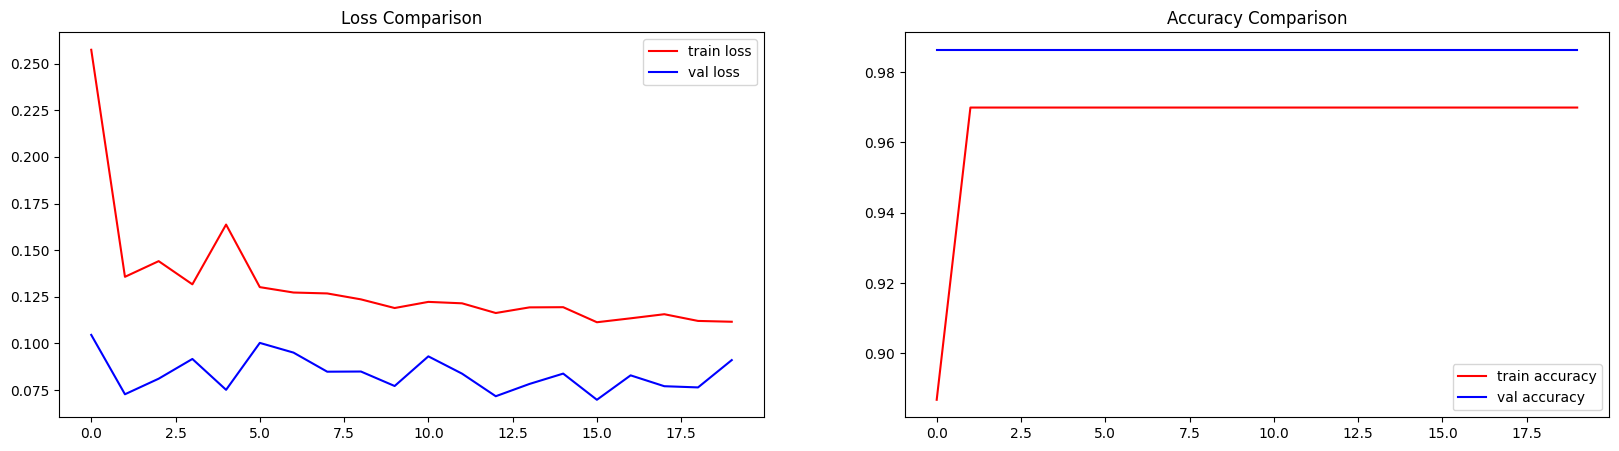

In [19]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'val loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'val accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

In [20]:
unet.evaluate(X_test, y_test)

2/2 [==============================] - 0s 138ms/step - loss: 0.1341 - accuracy: 0.9670


[0.13409501314163208, 0.9669873118400574]

In [21]:
def VisualizeResults(index):
    img = X_test[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_test[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_test[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

1/1 [==============================] - 2s 2s/step


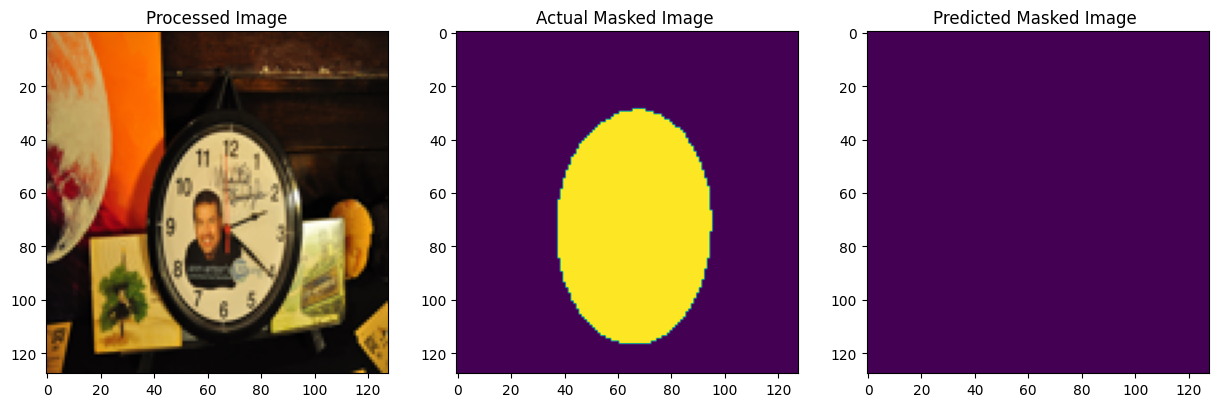

In [22]:
index = 1
VisualizeResults(index)

1/1 [==============================] - 0s 29ms/step


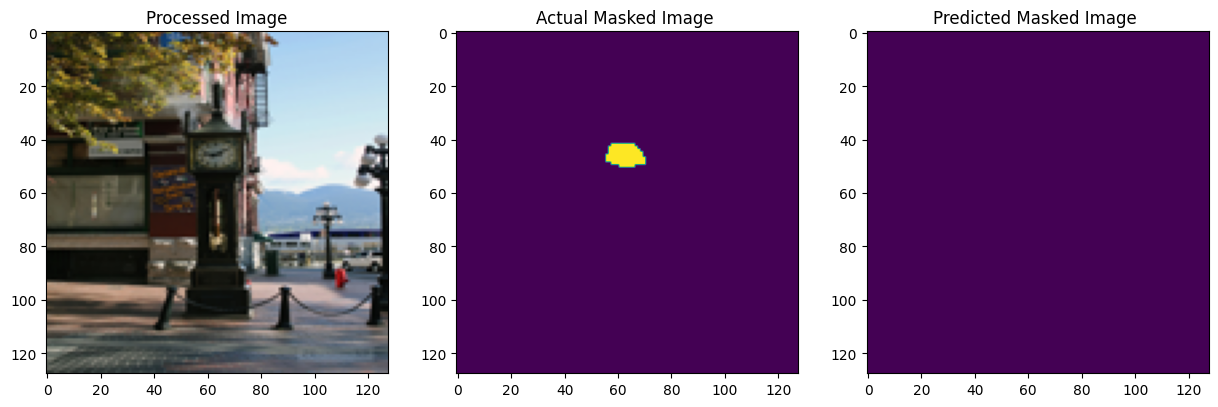

In [23]:
index = 2
VisualizeResults(index)

1/1 [==============================] - 0s 23ms/step


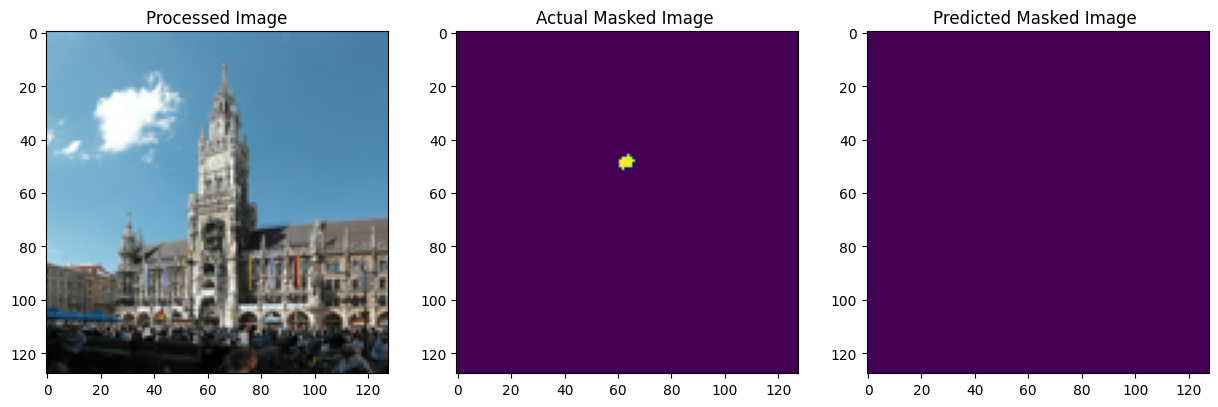

In [24]:
index = 3
VisualizeResults(index)

1/1 [==============================] - 0s 27ms/step


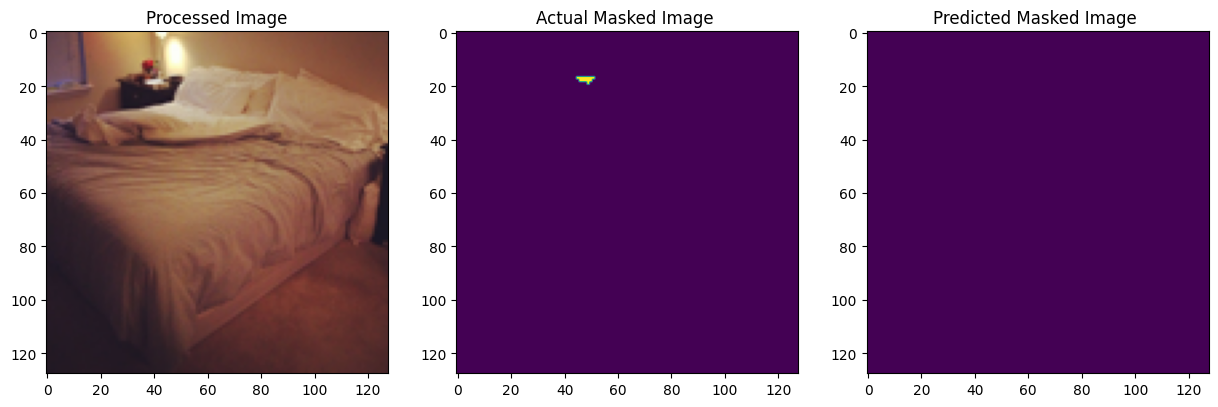

In [25]:
index = 4
VisualizeResults(index)

1/1 [==============================] - 0s 77ms/step


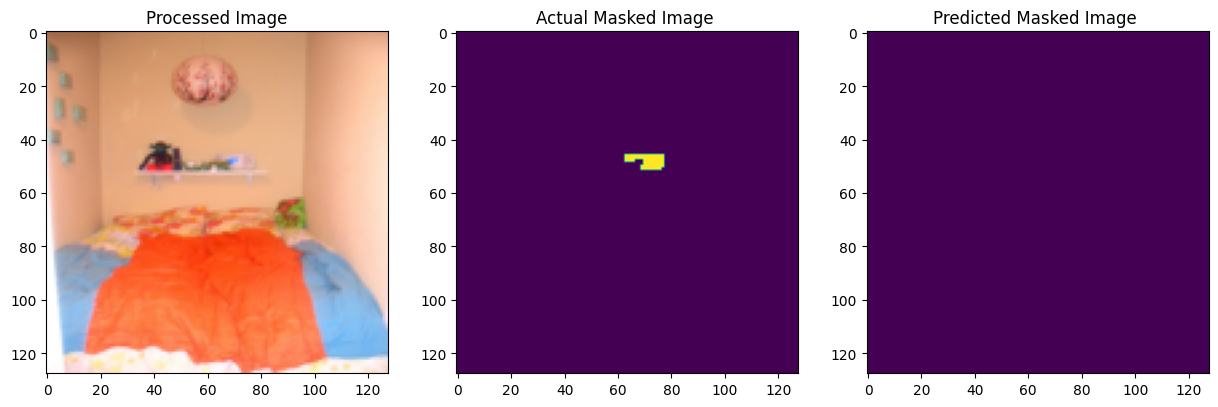

In [26]:
index = 5
VisualizeResults(index)

In [27]:
def VisualizeTrainResults(index):
    img = X_train[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_train[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_train[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

1/1 [==============================] - 0s 40ms/step


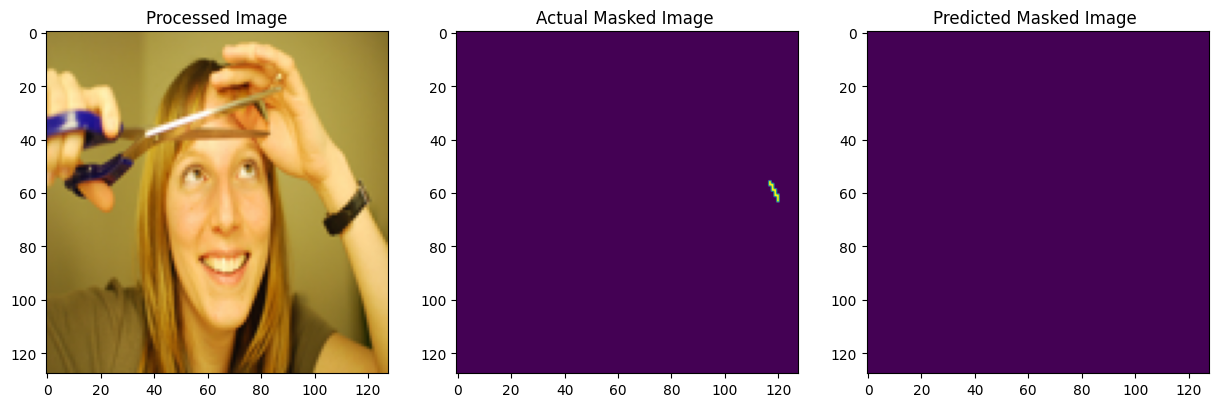

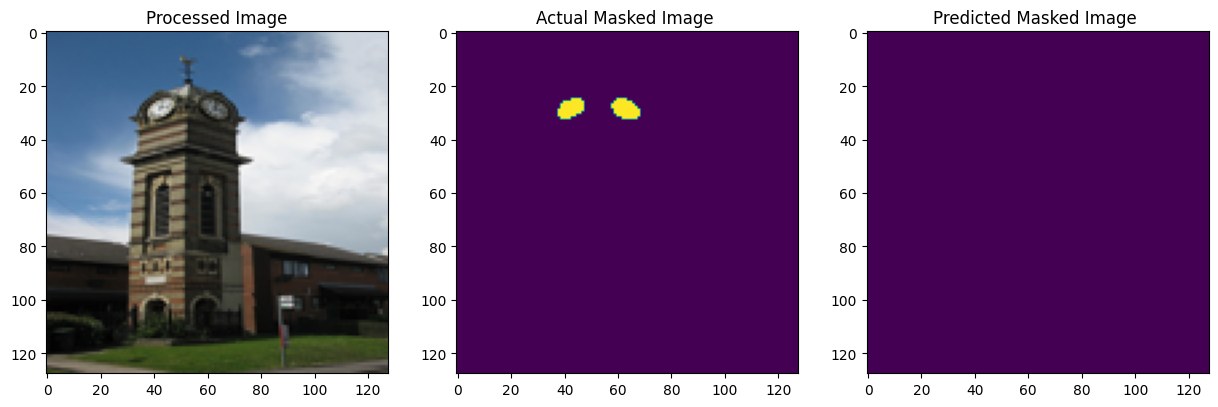

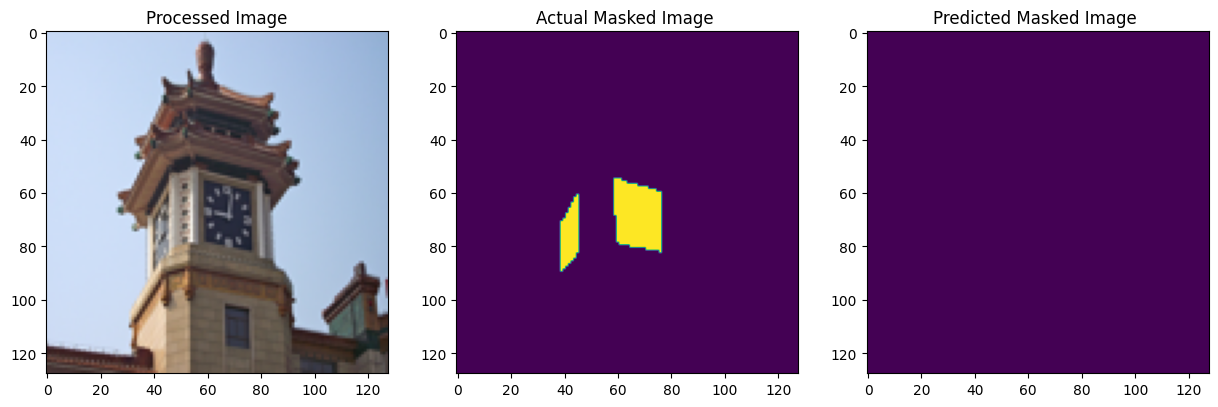

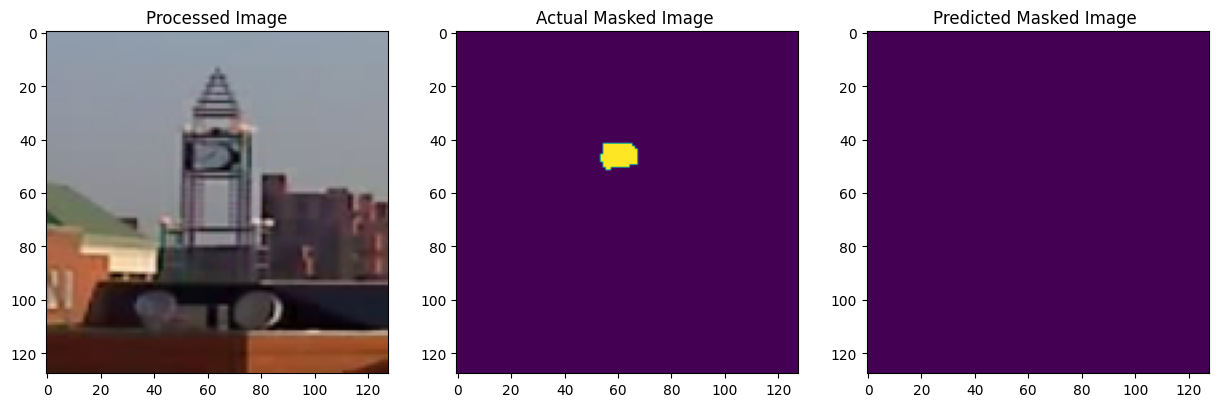

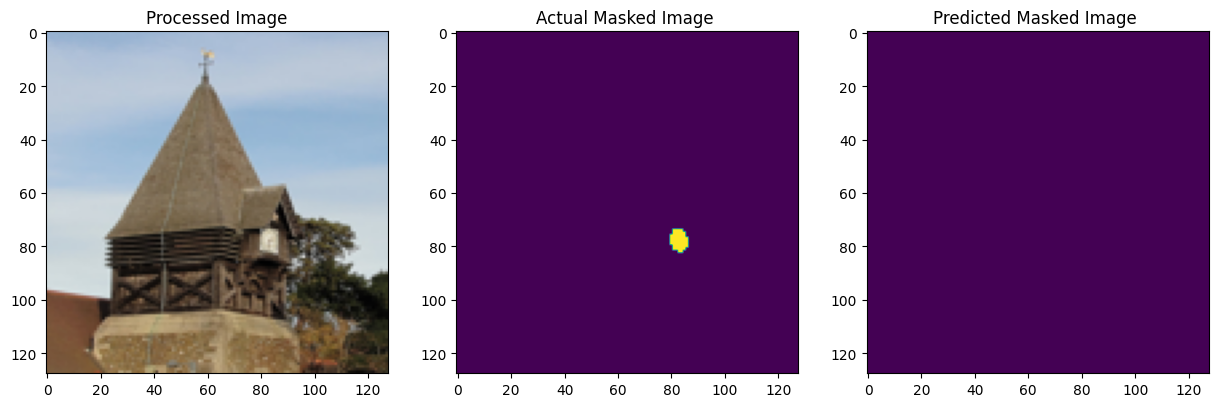

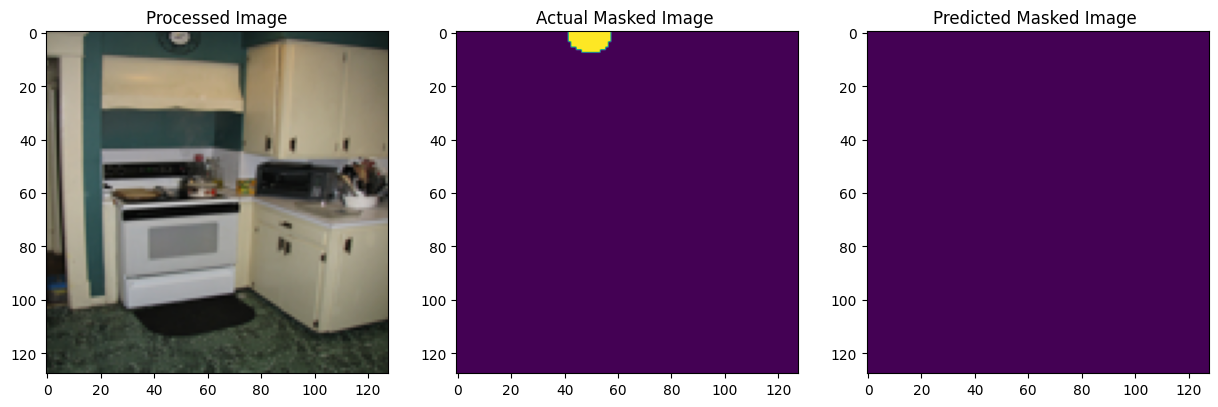

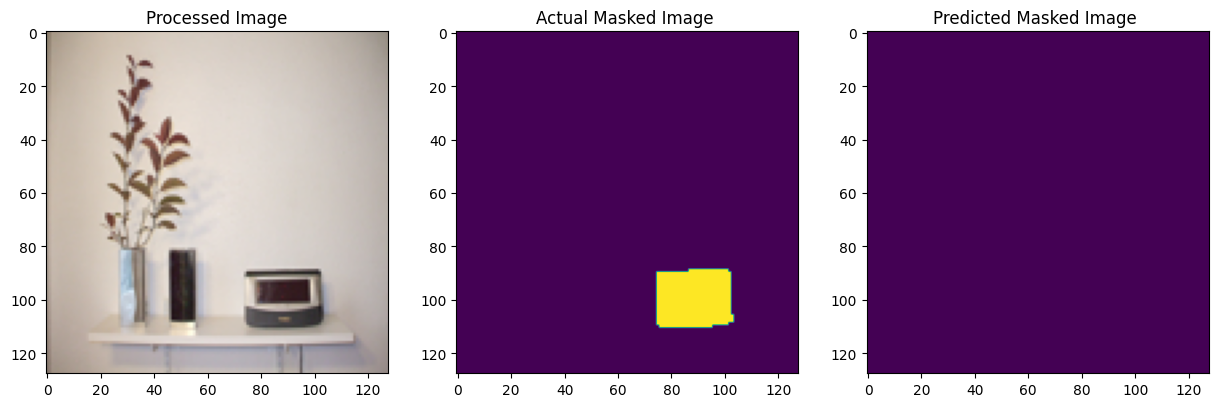

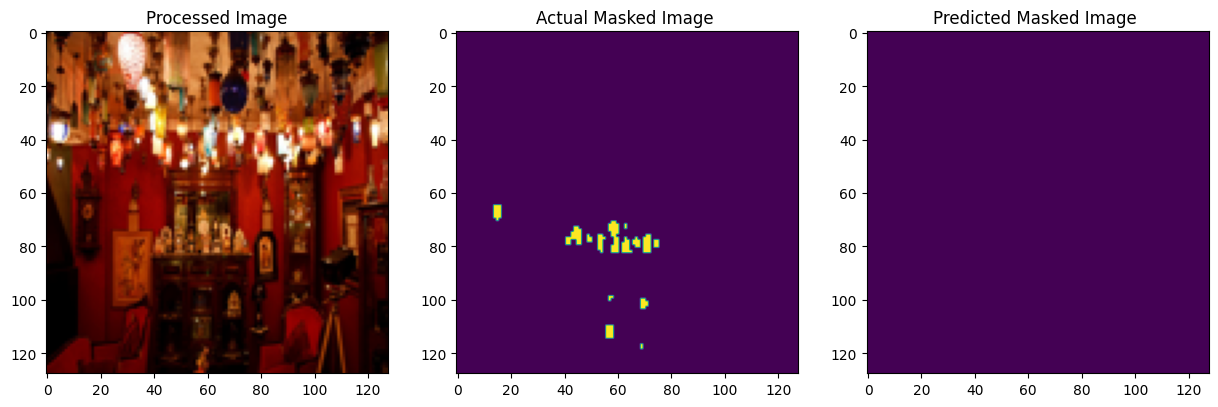

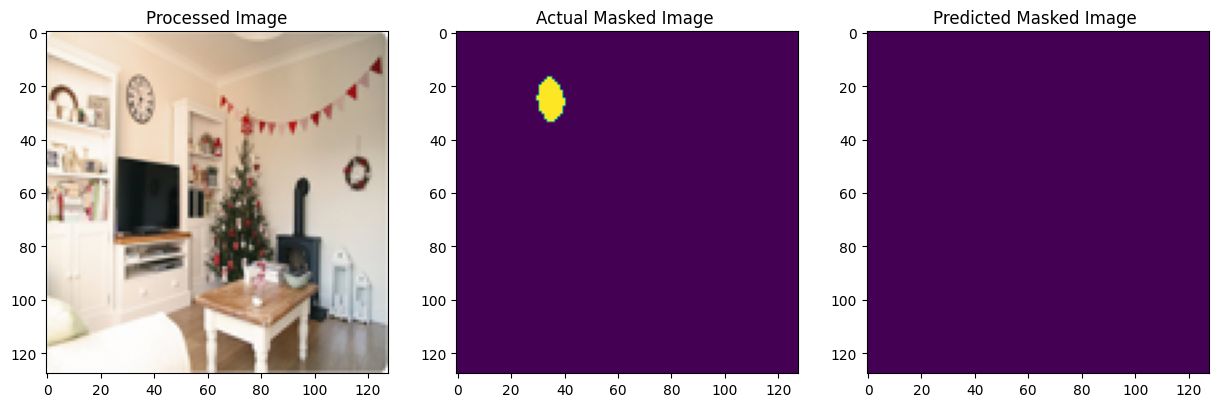

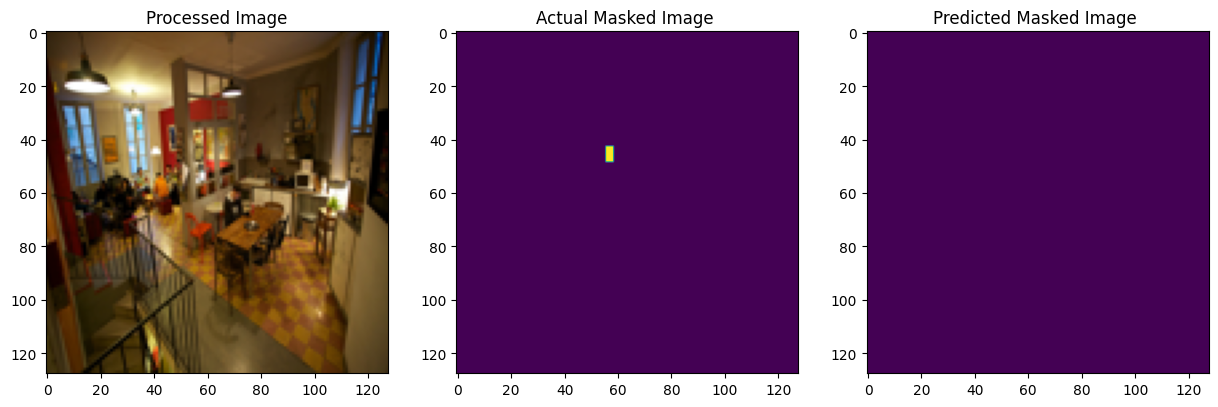

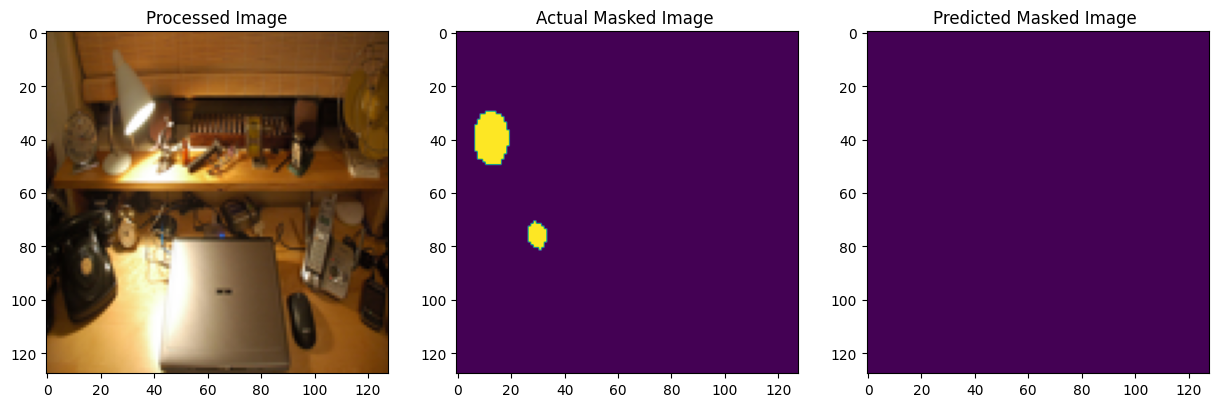

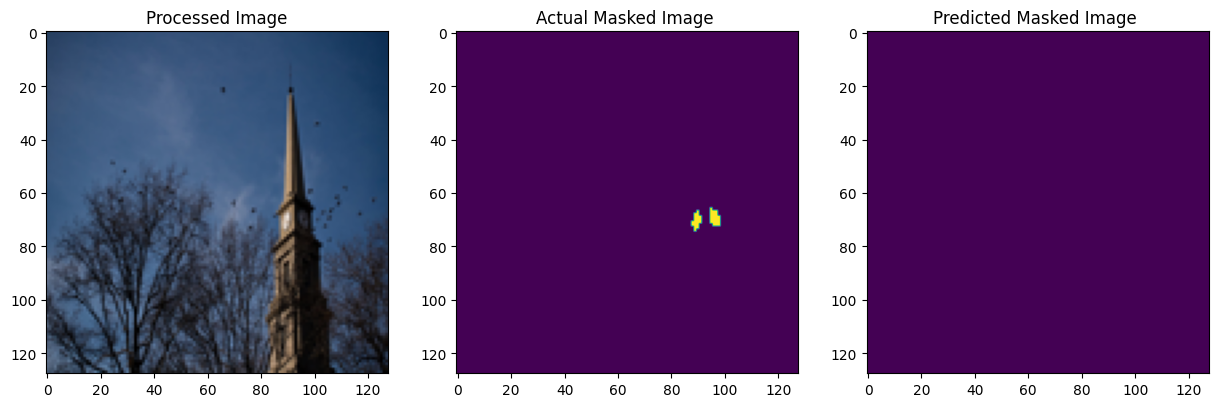

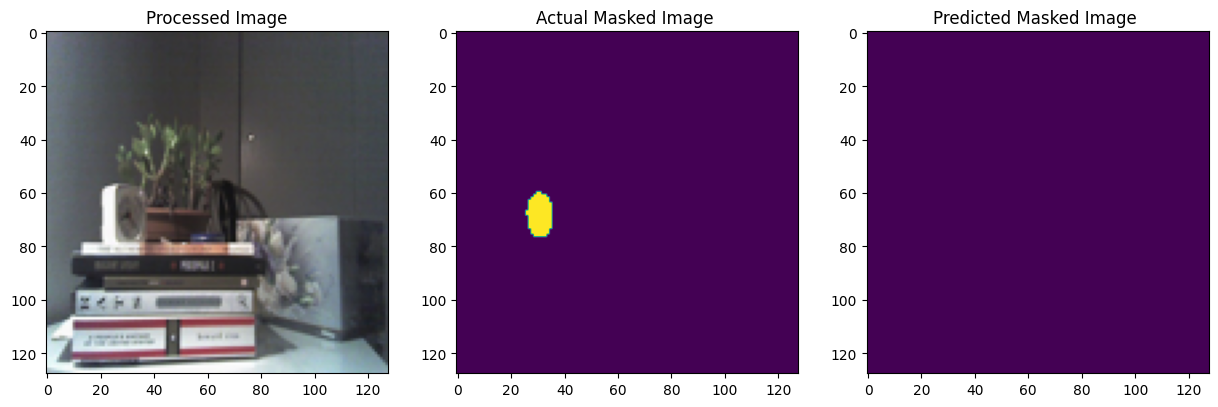

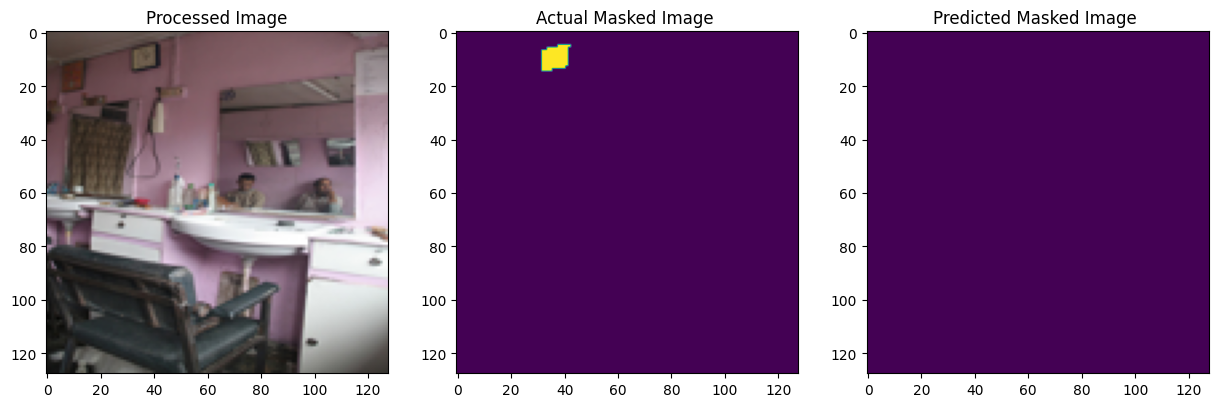

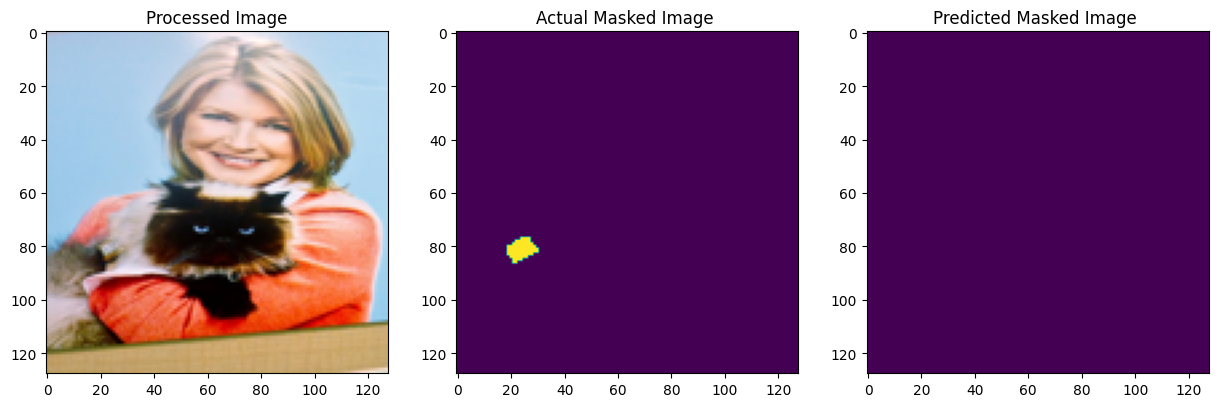

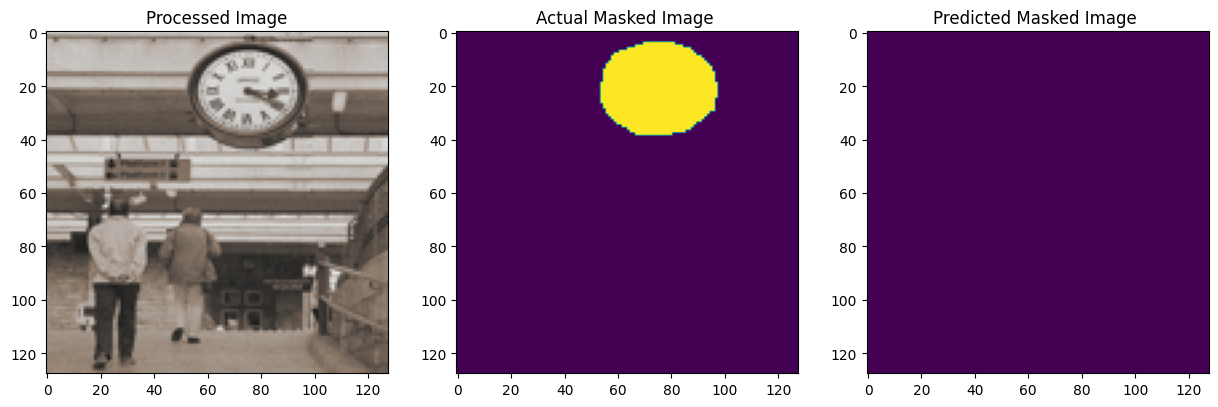

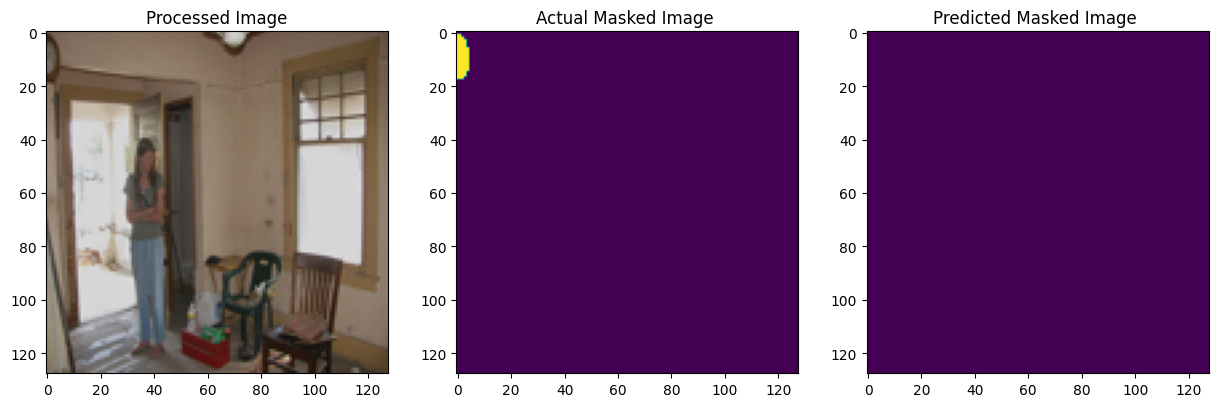

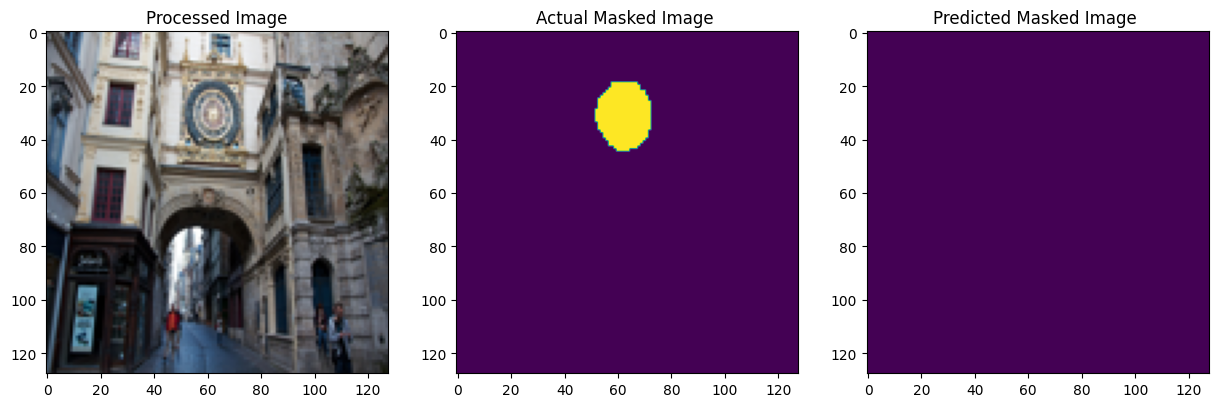

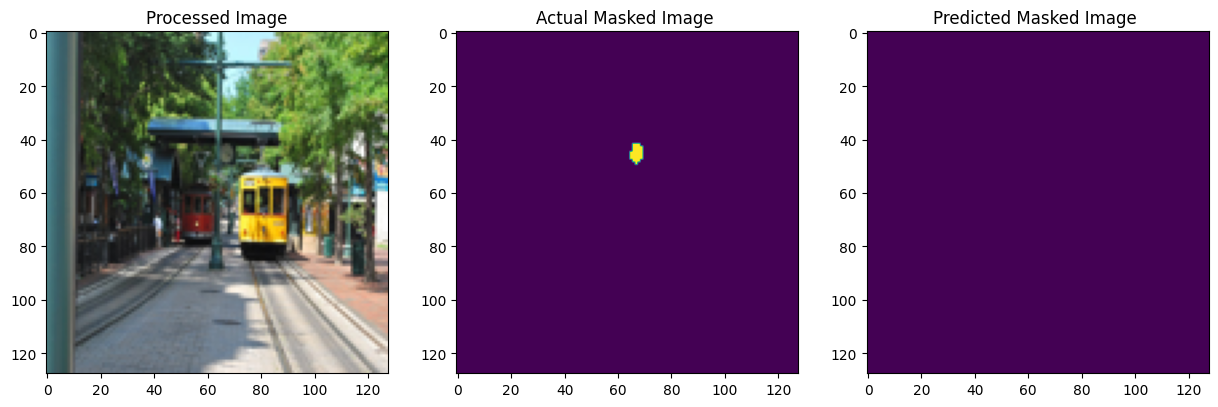

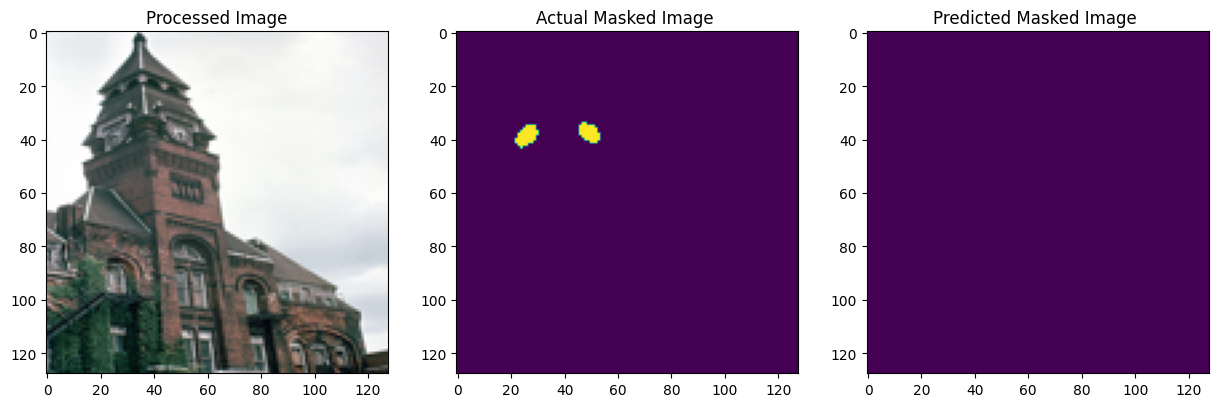

In [28]:
for i in range(20):
  index = i
  VisualizeTrainResults(index)